<a href="https://colab.research.google.com/github/abhipavi/Semantic-Segmentation-of-Dental-Images/blob/main/Dental_Segmentation_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install keras==2.1.5

In [ ]:
import os
import sys
import imgaug

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/Dental')
!pwd

/content/drive/My Drive/Dental


In [ ]:
import mrcnn.model as model_mask_lib
from mrcnn import visualize
from mrcnn.config import Config

import coco
from coco import CocoDataset
from coco import CocoConfig

Using TensorFlow backend.


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load Datasets 

#### Load Train

In [ ]:
#Load Dataset
dataset_train = coco.CocoDataset()
dir(dataset_train)
teeth_coco = dataset_train.load_coco("/content/drive/MyDrive/Dental/Data", "train", year=2018, return_coco=True, auto_download=False)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
dataset_train.prepare()

#### Load Val

In [ ]:
# Validation dataset
dataset_val = CocoDataset()
dataset_val.load_coco("/content/drive/MyDrive/Dental/Data", "val",  year=2018, return_coco=True, auto_download=False)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [ ]:
dataset_val.prepare()

#### Visualize dataset

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

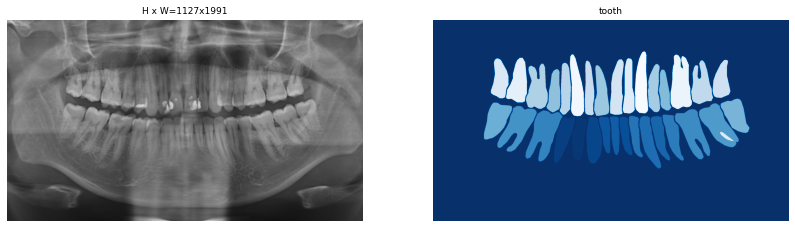

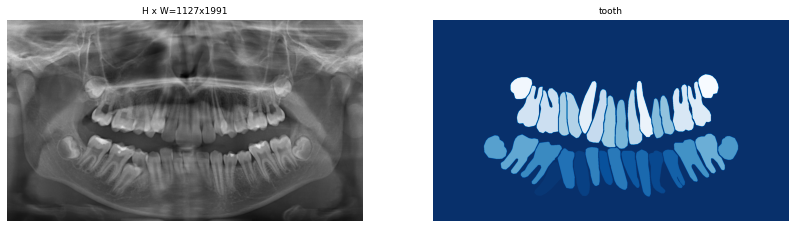

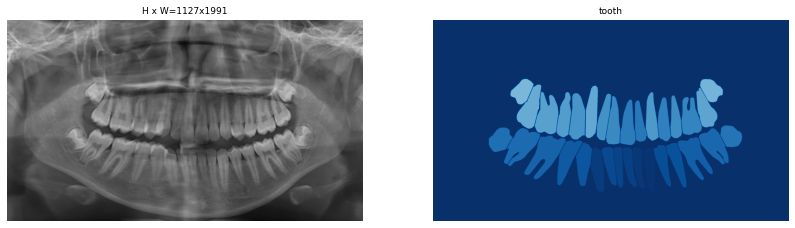

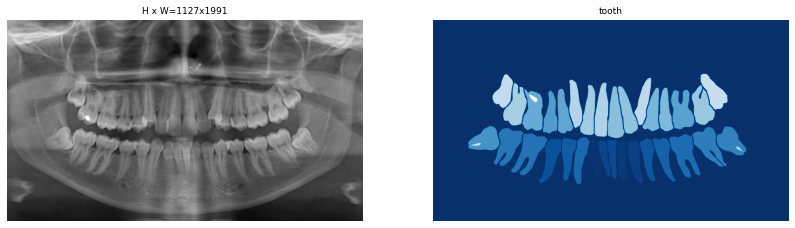

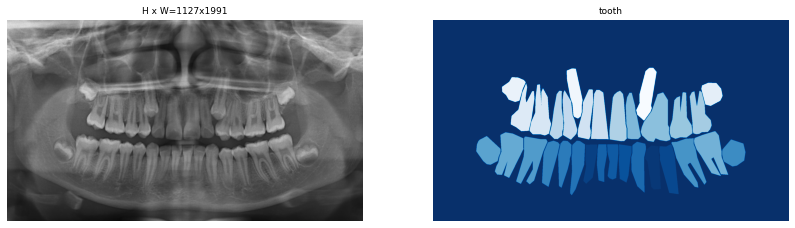

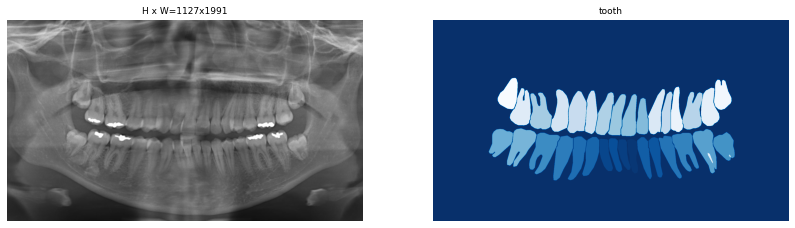

In [ ]:
image_ids = np.random.choice(dataset_train.image_ids, 6)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=1)

### Configuration from train 

In [ ]:
class TeethConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "teeth"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    
    STEPS_PER_EPOCH = 90

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # BG has 80 classes


In [ ]:
config_train = TeethConfig()
config_train.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
ROOT_LOGS = "/content/drive/MyDrive/Dental/logs"
model = model_mask_lib.MaskRCNN(mode="training", config=config_train, model_dir=ROOT_LOGS)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
#augmentation = imgaug.augmenters.Fliplr(0.5)
# Load weights
print("Loading weights")
model_path = "/content/drive/MyDrive/Dental/mask_rcnn_tooth.h5"
model.load_weights(model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Loading weights








In [ ]:
# Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config_train.LEARNING_RATE,
            epochs=10,
            layers='heads')

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config_train.LEARNING_RATE,
            epochs=15,
            layers='4+')

# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config_train.LEARNING_RATE,   
            epochs=20,
            layers='all')


Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Dental/logs/teeth20210430T0525/mask_rcnn_teeth_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4      

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
89/90 [============================>.] - ETA: 2s - loss: 1.6473 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 0.6363 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.3487

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


90/90 [==============================] - 489s 5s/step - loss: 1.6442 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 0.6350 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.2856 - mrcnn_mask_loss: 0.3480 - val_loss: 1.4942 - val_rpn_class_loss: 0.1245 - val_rpn_bbox_loss: 0.6067 - val_mrcnn_class_loss: 0.2869 - val_mrcnn_bbox_loss: 0.1988 - val_mrcnn_mask_loss: 0.2773
Epoch 2/10
90/90 [==============================] - 355s 4s/step - loss: 1.3641 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 0.5660 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.2041 - mrcnn_mask_loss: 0.2730 - val_loss: 1.4314 - val_rpn_class_loss: 0.1266 - val_rpn_bbox_loss: 0.5957 - val_mrcnn_class_loss: 0.2336 - val_mrcnn_bbox_loss: 0.2134 - val_mrcnn_mask_loss: 0.2621
Epoch 3/10
90/90 [==============================] - 355s 4s/step - loss: 1.3529 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.5914 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.1852 - mrcnn_mask_loss: 0.2570 - val_loss: 1.1810 - val_rpn_class_loss: 0.0774 - val

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 11/15
89/90 [============================>.] - ETA: 2s - loss: 1.0376 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.4387 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2226

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


90/90 [==============================] - 506s 6s/step - loss: 1.0329 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2223 - val_loss: 1.0019 - val_rpn_class_loss: 0.0626 - val_rpn_bbox_loss: 0.4191 - val_mrcnn_class_loss: 0.1858 - val_mrcnn_bbox_loss: 0.1170 - val_mrcnn_mask_loss: 0.2173
Epoch 12/15
90/90 [==============================] - 380s 4s/step - loss: 0.9953 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.4365 - mrcnn_class_loss: 0.1855 - mrcnn_bbox_loss: 0.1153 - mrcnn_mask_loss: 0.2150 - val_loss: 1.1101 - val_rpn_class_loss: 0.1149 - val_rpn_bbox_loss: 0.4877 - val_mrcnn_class_loss: 0.1823 - val_mrcnn_bbox_loss: 0.1026 - val_mrcnn_mask_loss: 0.2225
Epoch 13/15
90/90 [==============================] - 382s 4s/step - loss: 0.9093 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.3518 - mrcnn_class_loss: 0.1908 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2211 - val_loss: 1.1926 - val_rpn_class_loss: 0.0996 - v

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 16/20
89/90 [============================>.] - ETA: 3s - loss: 0.8388 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.3359 - mrcnn_class_loss: 0.1836 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


90/90 [==============================] - 527s 6s/step - loss: 0.8384 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2067 - val_loss: 0.9297 - val_rpn_class_loss: 0.0733 - val_rpn_bbox_loss: 0.3746 - val_mrcnn_class_loss: 0.1751 - val_mrcnn_bbox_loss: 0.0990 - val_mrcnn_mask_loss: 0.2076
Epoch 17/20
90/90 [==============================] - 399s 4s/step - loss: 0.7505 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2732 - mrcnn_class_loss: 0.1705 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.2001 - val_loss: 1.1073 - val_rpn_class_loss: 0.1060 - val_rpn_bbox_loss: 0.5173 - val_mrcnn_class_loss: 0.1704 - val_mrcnn_bbox_loss: 0.1058 - val_mrcnn_mask_loss: 0.2079
Epoch 18/20
90/90 [==============================] - 398s 4s/step - loss: 0.7274 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2677 - mrcnn_class_loss: 0.1678 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1962 - val_loss: 1.1311 - val_rpn_class_loss: 0.1554 - v

In [ ]:
model_path = os.path.join("/content/drive/MyDrive/Dental/", "mask_rcnn_dental.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(Config):
    NAME = 'teeth'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = model_mask_lib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=ROOT_LOGS)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/MyDrive/Dental/mask_rcnn_dental.h5
Loading weights from  /content/drive/MyDrive/Dental/mask_rcnn_dental.h5


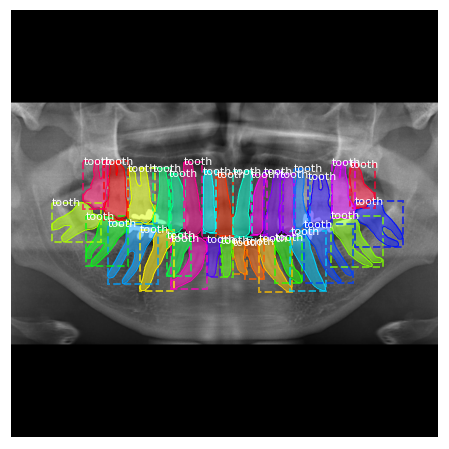

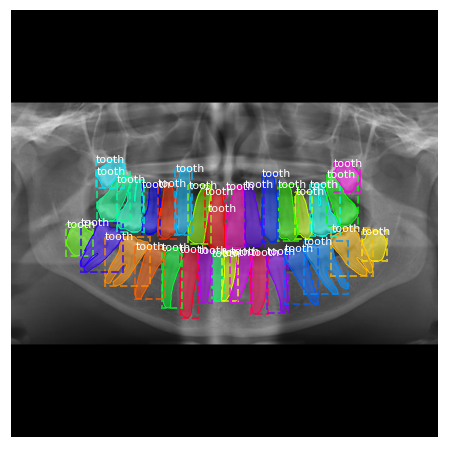

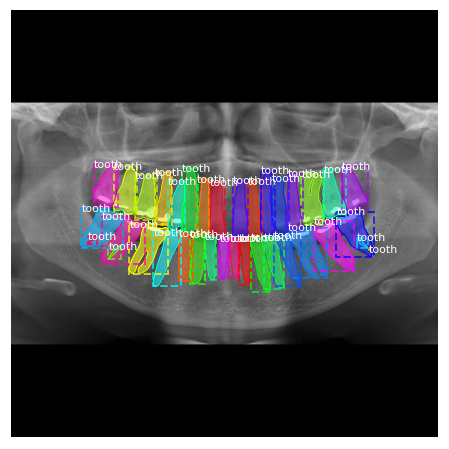

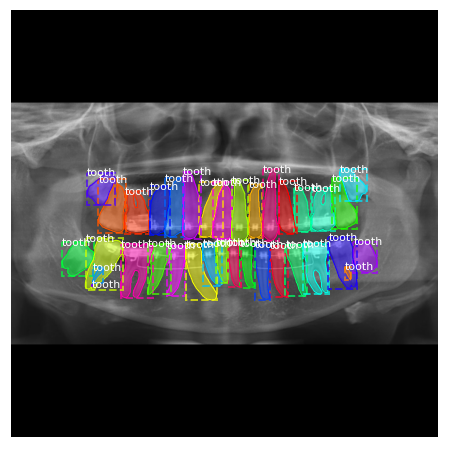

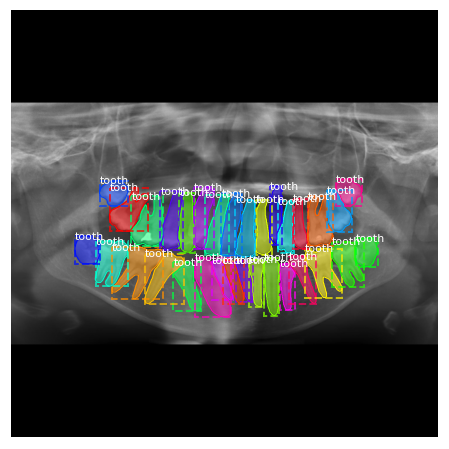

In [ ]:
image_ids = np.random.choice(dataset_val.image_ids,5)

for image_id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    model_mask_lib.load_image_gt(dataset_val, inference_config, 
                                  image_id, use_mini_mask=False)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                               dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


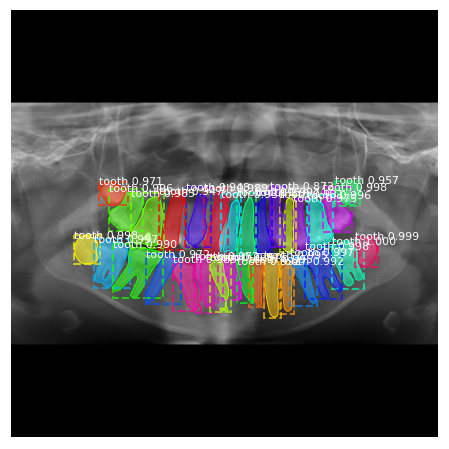

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

# Evaluation

In [ ]:
from mrcnn import utils
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        model_mask_lib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(model_mask_lib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9159199513663584
